# Synoptic types in Python: an analyis of circulation regimes over the New Zealand region

### import the stuff we need

In [1]:
%matplotlib inline
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from scipy.io import loadmat

In [2]:
from datetime import datetime, timedelta

In [3]:
from glob import glob

In [4]:
import pathlib

### making a list of the files to retrieve 

In [5]:
base_url = "ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/pressure/"

In [6]:
lonmin = 160.0
latmin = -55.0
lonmax = 185.0
latmax = -25.0
level = 1000.0

In [7]:
opath = pathlib.Path("/media/nicolasf/END19101/data/NCEP_NZ")

In [8]:
opath.mkdir(parents=True, exist_ok=True)

In [9]:
opath = str(opath)

In [10]:
# from subprocess import call
# for y in range(1958, 2021 + 1):
#     filename = "hgt.{}.nc".format(y)
#     cmd = "curl --silent {}/{} -o {}/{}".format(base_url, filename, opath, filename)
#     r = call(cmd, shell=True)
#     if r != 0:
#         print("something went wrong with the download of hgt.{}.nc".format(y))
#         pass
#     else:
#         dset = xr.open_dataset('{}/{}'.format(opath, filename))
#         dset = dset.sel(lat=slice(latmax, latmin), lon=slice(lonmin,lonmax), level=level)
#         dset = dset.squeeze()
#         os.remove('{}/{}'.format(opath, filename))
#         dset.to_netcdf('{}/{}'.format(opath, filename))
#         dset.close()

In [11]:
lfiles = glob(os.path.join(opath, "hgt*.nc"))

In [12]:
lfiles.sort()

### set a random seed to ensure reproducibility of the results 

In [13]:
np.random.seed(42)

In [14]:
dset = xr.open_mfdataset(lfiles, parallel=True)

In [15]:
dset = dset.drop(["time_bnds", "level"])

### select the period indicated to be utlized in the Kidson 2000 paper

In [16]:
dset = dset.sel(time=slice("1958-1-1", "1997-6-30"))

### calculates the time mean over the whole period

In [17]:
dsetm = dset.mean("time")

### mapping with [cartopy](http://scitools.org.uk/cartopy/)

In [18]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

In [19]:
lat = dset.lat
lon = dset.lon

In [20]:
lons, lats = np.meshgrid(lon, lat)

In [21]:
central_longitude = 180.0

In [22]:
proj = ccrs.PlateCarree(central_longitude=central_longitude)

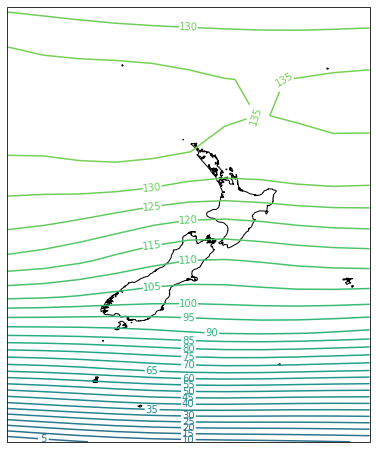

In [23]:
f, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": proj})

ax.coastlines("10m")

c = ax.contour(lons - central_longitude, lats, dsetm["hgt"], np.arange(-100, 200, 5))

plt.clabel(c, fmt="%i")

ax.set_extent(
    [
        lon.data.min() - central_longitude,
        lon.data.max() - central_longitude,
        lat.data.min(),
        lat.data.max(),
    ],
    crs=proj,
)

### make a function 

In [24]:
def make_map(
    X,
    lons,
    lats,
    vmin=-250,
    vmax=250,
    step=10,
    ax=None,
    central_longitude=180.0,
    fmt="%i",
):

    from numpy import ma

    if not (ax):
        central_longitude = 180.0
        proj = ccrs.PlateCarree(central_longitude=central_longitude)
        f, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": proj})

    proj = ccrs.PlateCarree(central_longitude=central_longitude)

    ax.coastlines("10m")

    if X.min() < 0 and X.max() > 0:
        p = ax.contour(
            lons - central_longitude,
            lats,
            ma.masked_less(X, 0),
            np.arange(0, vmax + step, step),
            colors="r",
        )
        n = ax.contour(
            lons - central_longitude,
            lats,
            ma.masked_greater(X, 0),
            np.arange(vmin, 0, step),
            colors="b",
        )

        ax.contour(lons - central_longitude, lats, X, np.array([0]), colors="k")

        plt.clabel(p, fmt=fmt)
        plt.clabel(n, fmt=fmt)
    elif X.min() < 0 and X.max() < 0:
        n = ax.contour(
            lons - central_longitude,
            lats,
            X,
            np.arange(vmin, vmax + step, step),
            colors="b",
        )
        plt.clabel(n, fmt=fmt)
    else:
        p = ax.contour(
            lons - central_longitude,
            lats,
            X,
            np.arange(vmin, vmax + step, step),
            colors="r",
        )
        plt.clabel(p, fmt=fmt)

    ax.set_extent(
        [
            lon.data.min() - central_longitude,
            lon.data.max() - central_longitude,
            lat.data.min(),
            lat.data.max(),
        ],
        crs=proj,
    )

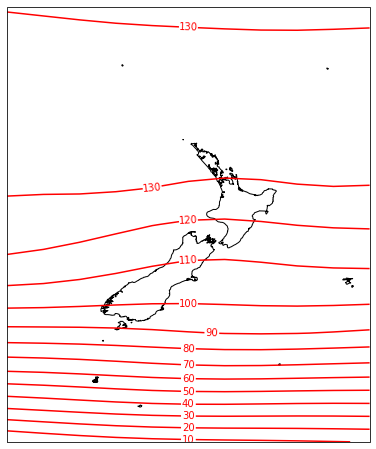

In [25]:
make_map(dsetm["hgt"].data, lons, lats)

In [26]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11, time: 14426)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
Data variables:
    hgt      (time, lat, lon) float32 dask.array<chunksize=(365, 13, 11), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC Reanalysis (1958)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    history:        created 97/10/04 by Hoop (netCDF2.3)\nConverted to chunke...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [27]:
hgt = dset["hgt"]

In [28]:
hgt

<xarray.DataArray 'hgt' (time: 14426, lat: 13, lon: 11)>
dask.array<getitem, shape=(14426, 13, 11), dtype=float32, chunksize=(366, 13, 11), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
Attributes:
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [ -700. 35000.]
    dataset:       NCEP Reanalysis Daily Averages
    actual_range:  [ -475.25 32282.  ]

### we now need to go from 3D (time, lat, lon) to 2D (time, space [lat X lon]) to perform the PCA (EOF) analyis

In [29]:
hgt_stacked = hgt.stack(latlon=("lat", "lon"))

In [30]:
hgt_stacked

<xarray.DataArray 'hgt' (time: 14426, latlon: 143)>
dask.array<reshape, shape=(14426, 143), dtype=float32, chunksize=(366, 143), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
  * latlon   (latlon) object MultiIndex
  * lat      (latlon) float32 -25.0 -25.0 -25.0 -25.0 ... -55.0 -55.0 -55.0
  * lon      (latlon) float32 160.0 162.5 165.0 167.5 ... 180.0 182.5 185.0
Attributes:
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [ -700. 35000.]
    dataset:       NCEP Reanalysis Daily Averages
    actual_range:  [ -475.25 32282.  ]

In [31]:
hgt.shape

(14426, 13, 11)

In [32]:
hgt_stacked.shape

(14426, 143)

In [33]:
type(hgt_stacked.data)

dask.array.core.Array

### we now need to LOAD the dataset in memory in order to perform the PCA (EOF analysis)

In [34]:
hgt_stacked.load()

<xarray.DataArray 'hgt' (time: 14426, latlon: 143)>
array([[ 84.,  92., 100., ..., -22., -39., -64.],
       [ 97.,  96.,  96., ...,  57.,  60.,  65.],
       [108., 104., 101., ...,  40.,  20.,   5.],
       ...,
       [132., 135., 136., ...,  63.,  49.,  34.],
       [126., 121., 116., ...,  32.,  24.,  14.],
       [133., 120., 107., ...,  46.,  40.,  30.]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
  * latlon   (latlon) object MultiIndex
  * lat      (latlon) float32 -25.0 -25.0 -25.0 -25.0 ... -55.0 -55.0 -55.0
  * lon      (latlon) float32 160.0 162.5 165.0 167.5 ... 180.0 182.5 185.0
Attributes:
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [ -700. 35000.]
    dataset:       NCEP Reanalysis Daily Averages
    actual_range:  [ -475.25 32282.  ]

In [35]:
type(hgt_stacked.data)

numpy.ndarray

In [36]:
X = hgt_stacked.data

In [37]:
X.shape

(14426, 143)

In [38]:
type(X)

numpy.ndarray

The number of variables (features) is 143 (13 points in latitude * 11 points in longitude): while we can attend to perform our cluster analysis directly on this matrix, 
it is expensive computationally, i.e. each day (observation) is associated to a point with 143 coordinates, we need to find clusters in 143 dimensions ...

The approach generally taken is to **reduce the dimensionality** of the original dataset using methods such as [Principal Component (or Empirical Orthoginal Function) Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). This is the approach that has been used by Kidson, and we will try and follow the way he processed the data as described in the paper.

## do PCA / EOF analysis of daily geopotential fields

To perform the PCA, we will use the excellent (not enough superlatives here !) [scikit-learn](http://scikit-learn.org/) Machine Learning library  

**Scikit-learn** implements a wide array of [supervised](http://en.wikipedia.org/wiki/Supervised_learning) and [unsupervised](http://en.wikipedia.org/wiki/Unsupervised_learning) Machine Learning algorithms, 

**Unsupervised** refers to algorithms which learn from a training set of unlabeled examples, using the features of the inputs to categorize inputs together according to some statistical criteria.

Unsupervised learning algorithms are usually separated into :

+ [Dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions) , whicn *learns* a more compact representation  of the data (i.e. reducing the dimensions).

+ [Clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering)


scikit-learn exposes a very useful [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) submodule, which allows to do various transformations on your input data, in this case we will *standardisation* the dataset, removing the mean and dividing by the standard deviation ... 

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()

In [41]:
scaler = scaler.fit(X)

In [42]:
X = scaler.transform(X)

In [43]:
X.shape

(14426, 143)

In [44]:
X.mean(0)

array([-1.09902004e-07, -1.09316844e-07,  1.26795186e-07,  4.87009544e-08,
        1.96204482e-07, -1.28249562e-08,  6.78846774e-08, -3.60701904e-08,
       -6.35711288e-08, -5.33822275e-09, -3.39748745e-08,  4.72858289e-07,
       -7.58011112e-08,  2.66233542e-07,  1.41892599e-07,  7.89495047e-08,
       -9.89141302e-09,  7.78339313e-08,  1.41305891e-08, -2.08364213e-07,
       -4.43336923e-09, -5.44203305e-09, -1.19498509e-07, -1.89895299e-08,
       -1.75516792e-08, -3.81278014e-08, -3.00130409e-08, -1.50395751e-09,
        5.25062944e-08, -8.56098836e-09,  3.54413373e-07,  6.49098153e-09,
       -2.15357208e-08,  5.02482926e-08,  2.04513435e-06,  3.37233530e-08,
       -3.52025218e-08,  4.53170479e-08, -5.47043877e-09, -6.10507556e-08,
       -6.92481539e-09, -5.83816480e-08,  2.39600269e-08, -5.26147552e-08,
        2.42885001e-08,  5.82618256e-08,  7.65200348e-09,  1.26844766e-08,
        2.43442795e-08,  2.80298007e-08,  3.07402304e-09, -7.60820669e-08,
        3.39629969e-09,  

In [45]:
X.mean()

7.100834e-10

In [46]:
X.std(0)

array([0.9999973 , 0.999999  , 0.9999973 , 0.9999931 , 0.99999416,
       0.999993  , 0.99999857, 0.99999326, 1.0000046 , 0.9999955 ,
       1.0000068 , 1.0000054 , 0.99999726, 0.9999931 , 1.0000052 ,
       0.99999976, 0.9999946 , 0.99999344, 0.999999  , 1.0000038 ,
       0.9999968 , 1.000008  , 1.0000045 , 0.99998623, 0.9999967 ,
       1.0000054 , 0.9999992 , 1.0000136 , 0.99999547, 1.        ,
       0.9999948 , 0.9999941 , 0.9999956 , 1.0000018 , 0.9999971 ,
       0.9999916 , 1.0000043 , 1.0000086 , 0.999993  , 0.99999934,
       0.9999983 , 1.000007  , 1.0000015 , 1.000002  , 0.9999918 ,
       1.0000019 , 0.9999972 , 1.000004  , 0.9999977 , 0.99999416,
       0.99999547, 0.9999981 , 0.9999905 , 1.0000035 , 1.0000035 ,
       0.9999987 , 1.0000019 , 0.99999493, 1.0000046 , 0.99999917,
       1.000003  , 0.9999977 , 0.99999577, 0.9999977 , 0.9999927 ,
       0.9999947 , 1.0000031 , 1.0000033 , 0.9999954 , 0.9999997 ,
       1.0000032 , 1.0000013 , 1.0000014 , 0.99999785, 0.99999

### The pca class itself is in the *decomposition* submodule of scikit-learn

In [47]:
from sklearn.decomposition import PCA

In [48]:
skpca = PCA()

In [49]:
skpca.fit(X)

PCA()

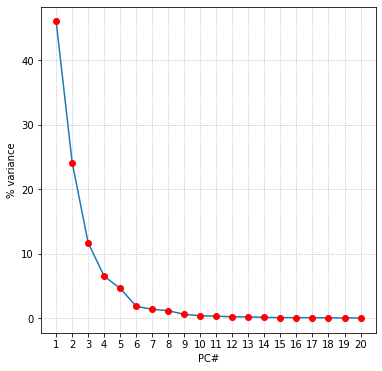

In [50]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot(range(1, 21), skpca.explained_variance_ratio_[0:20] * 100)
ax.plot(range(1, 21), skpca.explained_variance_ratio_[0:20] * 100, "ro")
ax.grid(ls=":")
ax.set_xticks(range(1, 21))
ax.set_xlabel("PC#")
ax.set_ylabel("% variance");

### In his paper, Kidson keeps the first 5 Principal Components and perform the cluster analysis on the subspace spanned by these 5 PCs

In [51]:
ipc = 5

In [52]:
skpca.explained_variance_ratio_[:ipc].sum()

0.9295687

Together they explain more than 90% of the total variance contained in the dataset

In [53]:
PCs = skpca.transform(X)

In [54]:
PCs = PCs[:, :ipc]

### the EOFS contain the spatial patterns associated with each PC

In [55]:
EOFs = skpca.components_

In [56]:
EOFs = EOFs[:ipc, :]

In [57]:
EOFs.shape

(5, 143)

In [58]:
EOFs_r = EOFs.reshape((ipc, len(lat), len(lon)))

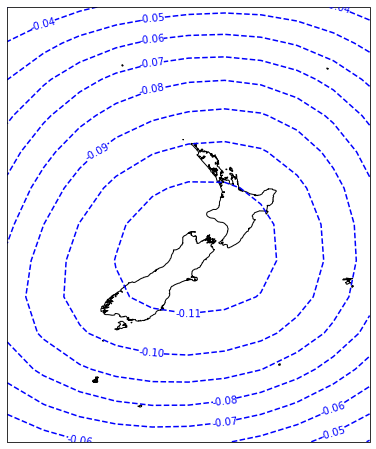

In [59]:
make_map(EOFs_r[0, :, :], lons, lats, vmin=-0.2, vmax=0.2, step=0.010, fmt="%4.2f")

In his paper, not clear whether Kidson *scaled* (standardised) the PCs or not, trying with and without standardisation seem to indicated he DID NOT standardise the PCs prior to the cluster analysis

In [60]:
# scaler_PCs = StandardScaler()
# scaler_PCs.fit(PCs)
# PCs_std = scaler_PCs.transform(PCs)

In [61]:
PCdf = pd.DataFrame(
    PCs, index=dset["time"], columns=["PC%s" % (x) for x in range(1, PCs.shape[1] + 1)]
)

In [62]:
PCdf.head()

,PC1,PC2,PC3,PC4,PC5
1958-01-01,6.536854,0.847300,-0.263598,1.135560,0.381244
1958-01-02,3.440390,0.996311,-3.569781,1.233637,0.971460
1958-01-03,3.250609,0.405964,-2.433801,0.781609,0.833162
1958-01-04,4.767938,1.048908,-2.495416,-1.639445,0.603463
1958-01-05,6.542261,0.989103,-4.496959,-3.824619,0.658478


In [63]:
PCdf.tail()

,PC1,PC2,PC3,PC4,PC5
1997-06-26,-12.724702,-2.764827,-2.328735,-0.227634,5.316721
1997-06-27,-11.619931,-1.326138,-2.331677,1.111571,5.978145
1997-06-28,-10.410846,3.613840,0.567940,-0.202117,5.679651
1997-06-29,-6.501851,7.211429,3.601358,1.466811,5.148717
1997-06-30,0.006125,10.749048,-1.592842,1.393158,1.898785


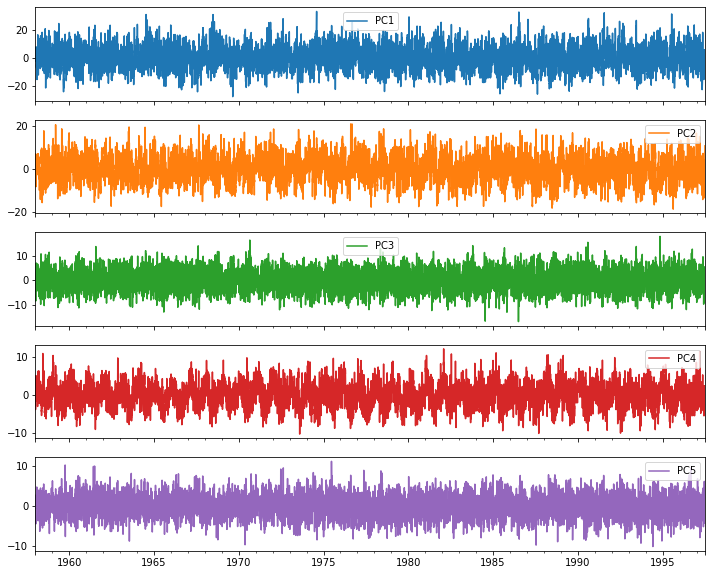

In [64]:
PCdf.plot(subplots=True, figsize=(12, 10));

### The K-means clustering class is found in the [clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering) submodule of scikit-learn

In [65]:
from sklearn.cluster import KMeans

#### specify the number of clusters here ... 

In [66]:
nclusters = 12

#### initialise the KMeans class with the parameters, n_jobs=-1 means the computations will be distributed accross the cores of your machine (if you have a multicore CPU)

In [67]:
kmeans = KMeans(init="k-means++", n_clusters=nclusters, n_init=10)

#### fit ... 

In [68]:
kmeans.fit(PCdf.values)

KMeans(n_clusters=12)

#### `kmeans.labels_` contains the unique labels for each day: i.e. a number from 0 to nclusters-1 indicating to which cluster (regime) each day belongs

In [69]:
kmeans.labels_

array([7, 3, 3, ..., 9, 9, 4], dtype=int32)

In [70]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

#### we put that into a Pandas DataFrame and assign the corresponding date to each day 

In [71]:
labels = pd.DataFrame(kmeans.labels_, index=dset["time"], columns=["cluster"])

In [72]:
labels.head()

,cluster
1958-01-01,7
1958-01-02,3
1958-01-03,3
1958-01-04,2
1958-01-05,1


In [73]:
c = 0

In [74]:
index = labels.query("cluster == {}".format(c))

In [75]:
nbdays = len(index)

In [76]:
nbdays

1380

In [77]:
cluster = dset.sel(time=index.index).mean("time")

In [78]:
cluster

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
Data variables:
    hgt      (lat, lon) float32 dask.array<chunksize=(13, 11), meta=np.ndarray>

In [79]:
clusters = []
nbdays = []
for c in range(nclusters):
    index = labels.query("cluster == {}".format(c))
    nbdays.append(len(index))
    cluster = dset.sel(time=index.index).mean("time")
    clusters.append(cluster)

In [80]:
clusters = xr.concat(clusters, dim="cluster")

In [81]:
clusters

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11, cluster: 12)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
Dimensions without coordinates: cluster
Data variables:
    hgt      (cluster, lat, lon) float32 dask.array<chunksize=(1, 13, 11), meta=np.ndarray>

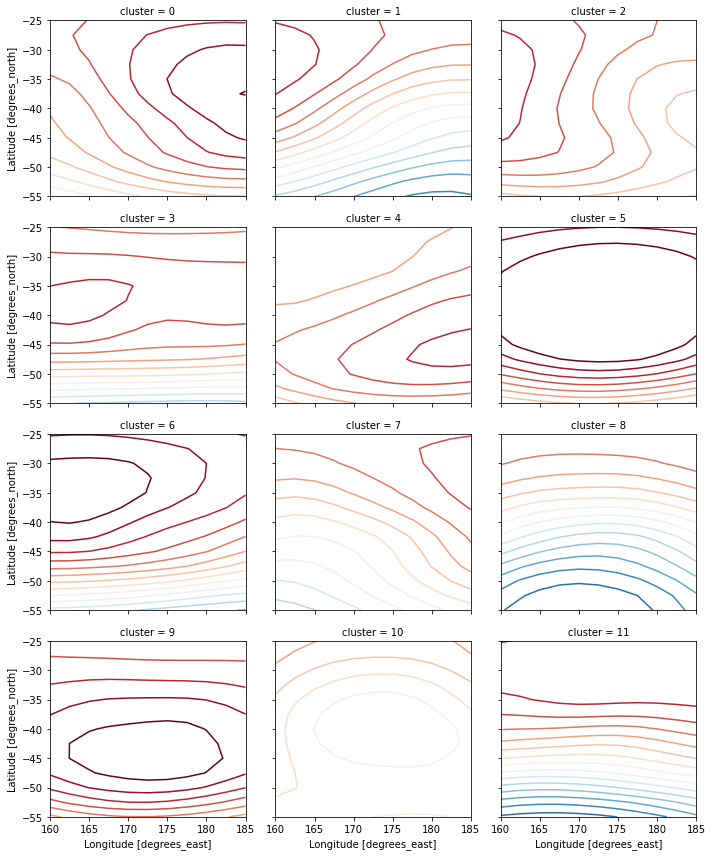

In [82]:
f = clusters["hgt"].plot.contour(
    x="lon", y="lat", col="cluster", col_wrap=3, levels=np.arange(-150, 200, 20)
)

In [83]:
sum(nbdays)

14426

In [84]:
clusters

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11, cluster: 12)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
Dimensions without coordinates: cluster
Data variables:
    hgt      (cluster, lat, lon) float32 dask.array<chunksize=(1, 13, 11), meta=np.ndarray>

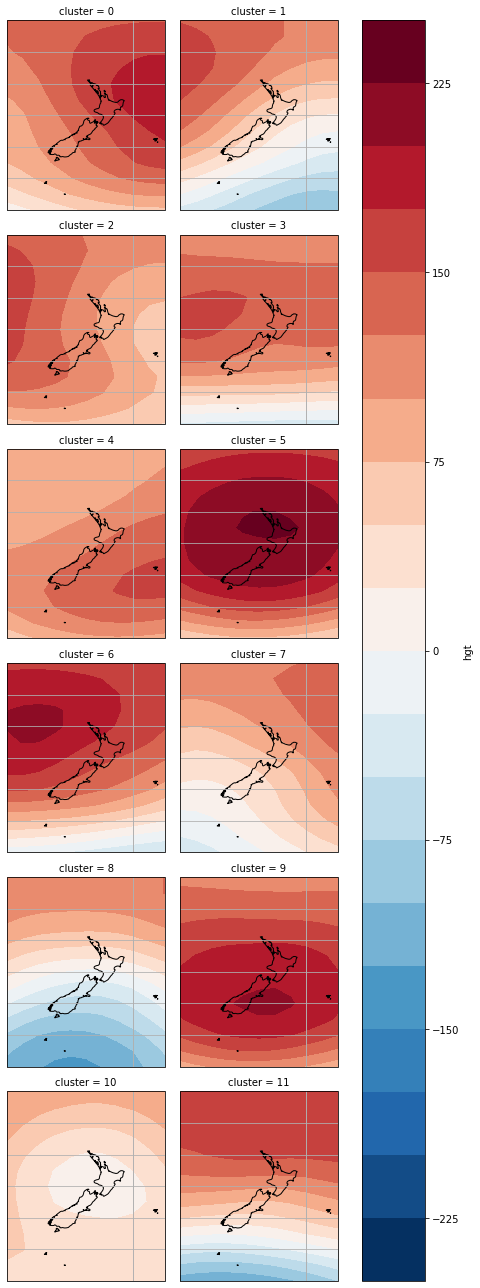

In [85]:
p = clusters["hgt"].plot.contourf(
    levels=20,
    transform=ccrs.PlateCarree(),
    col="cluster",
    col_wrap=2,
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
)

for ax in p.axes.flat:

    ax.coastlines()
    ax.gridlines()

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


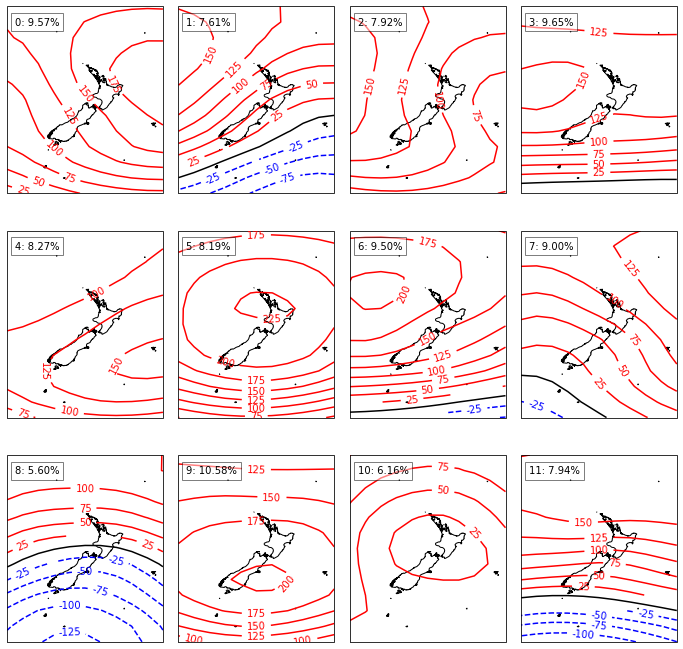

In [86]:
f, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,12), subplot_kw={'projection':proj})
f.subplots_adjust(wspace=0.1, hspace=0.1)
axes = axes.flatten()
for c in range(nclusters):
    ax = axes[c]
    clus = clusters.sel(cluster=c)
    make_map(clus['hgt'], lons, lats, step=25, ax=ax)
    ax.text(0.05, 0.9, "{}: {:3.2f}%".format(c, nbdays[c] / sum(nbdays) * 100), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))

## loads the clusters from James 

In [87]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/Kidson') 

fname = "clusters_daily.mat"

matfile = loadmat(dpath.joinpath(fname), struct_as_record=False)

KT_james = matfile['clusters'][0,0]

tclus = KT_james.time

In [88]:
name = KT_james.name

In [89]:
names = [x[0][0] for x in name]

In [90]:
dates = [datetime(*x) for x in tclus]

In [91]:
df_KT = pd.DataFrame(names, index=dates, columns=['KT'])

### selects the 12Z KT 

In [92]:
df_KT = df_KT.loc[df_KT.index.hour == 0,:]

### casts the index into a date (no hour info)

In [93]:
df_KT.index = df_KT.index.date

In [94]:
df_KT.head()

,KT
1948-01-01,TNW
1948-01-02,NE
1948-01-03,NE
1948-01-04,NE
1948-01-05,NE


In [95]:
df_KT = df_KT.loc[labels.index,:]

In [96]:
df_KT 

,KT
1958-01-01,TSW
1958-01-02,SW
1958-01-03,SW
1958-01-04,TSW
1958-01-05,TSW
...,...
1997-06-26,H
1997-06-27,H
1997-06-28,H
1997-06-29,HSE


In [97]:
df_KT.index.name = 'time'
labels.index.name = 'time'

In [98]:
dset['KT'] = df_KT.to_xarray()['KT']

In [99]:
dset['labels'] = labels.to_xarray()['cluster']

In [100]:
df_KT_labels = pd.concat([df_KT, labels], axis=1)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/pandas/core/dtypes/missing.py:506: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return lib.array_equivalent_object(


In [101]:
df_KT_labels.groupby('KT').mean()

,cluster
KT,
H,5.001575
HE,2.165039
HNW,5.723425
HSE,6.219067
HW,4.117105
NE,4.094818
R,3.417665
SW,3.853733
T,6.706516


In [110]:
!pwd

/home/nicolasf/research/PICT_notebooks/notebooks/make_datasets


In [111]:
df_u = df_KT_labels.groupby('KT')['cluster'].value_counts().unstack()

In [114]:
df_u 

cluster,0,1,2,3,4,5,6,7,8,9,10,11
KT,,,,,,,,,,,,
H,200.0,NaN,14.0,148.0,NaN,894.0,427.0,NaN,NaN,209.0,NaN,13.0
HE,642.0,NaN,10.0,106.0,35.0,49.0,26.0,82.0,NaN,25.0,NaN,49.0
HNW,32.0,9.0,32.0,152.0,NaN,30.0,643.0,4.0,NaN,2.0,NaN,112.0
HSE,279.0,NaN,52.0,155.0,175.0,199.0,2.0,1.0,NaN,1109.0,NaN,NaN
HW,16.0,1.0,223.0,259.0,51.0,10.0,49.0,1.0,NaN,150.0,NaN,NaN
NE,111.0,NaN,33.0,26.0,588.0,NaN,NaN,88.0,NaN,8.0,53.0,NaN
R,4.0,3.0,277.0,94.0,233.0,NaN,3.0,8.0,NaN,22.0,24.0,NaN
SW,7.0,688.0,198.0,256.0,2.0,NaN,113.0,26.0,66.0,NaN,9.0,269.0
T,8.0,321.0,42.0,53.0,NaN,NaN,1.0,342.0,671.0,NaN,92.0,235.0


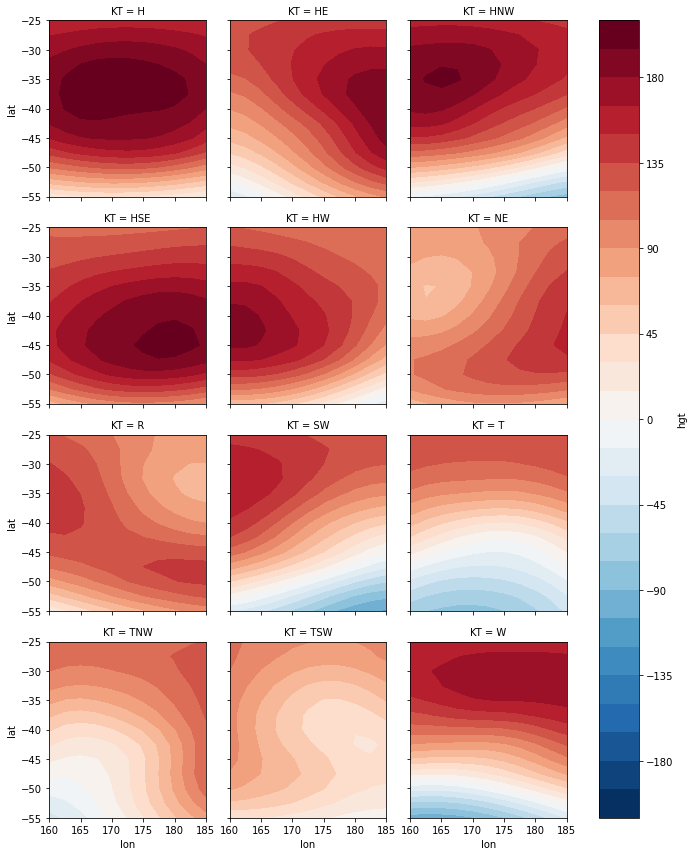

In [125]:
dset.groupby('KT').mean()['hgt'].plot.contourf(col='KT', col_wrap=3, levels=30)

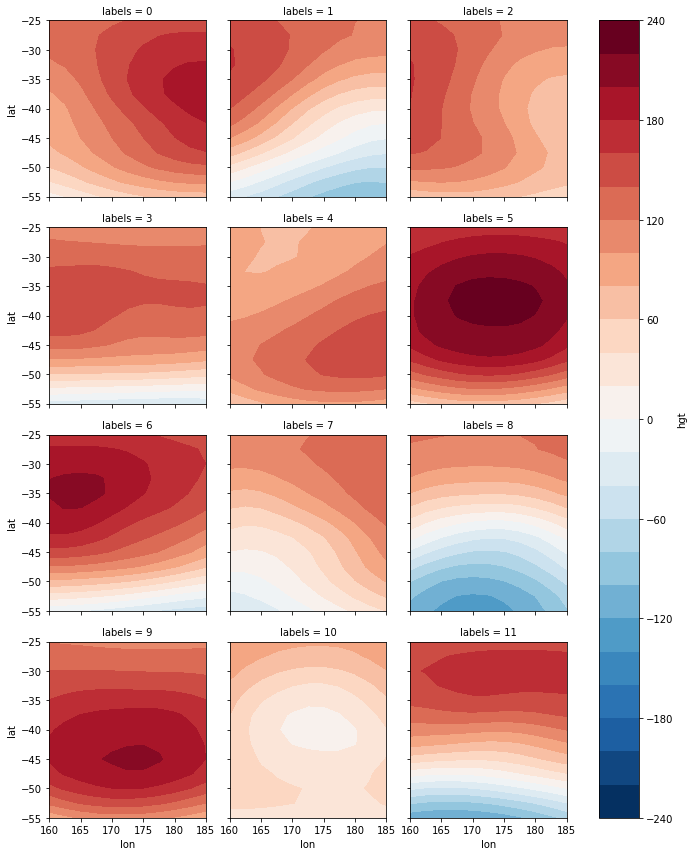

In [127]:
dset.groupby('labels').mean()['hgt'].plot.contourf(col='labels', col_wrap=3, levels=30)

In [90]:
f.savefig("/home/nicolasf/Desktop/Kidson_clusters.png", dpi=200)

In [ ]:
!open ./images/Kidson_Archetypes.png

In [ ]:
Image("./images/Kidson_Archetypes.png", width=700)

### look at the seasonal distribution of the synoptic types / weather regimes

In [ ]:
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 14))
axes = axes.flatten()
for c in range(nclusters):
    ax = axes[c]
    cf = labels.query("cluster == {}".format(c))
    # in percentage
    ((cf.groupby(cf.index.month).count()) / len(cf) * 100).plot(
        kind="bar", width=1, ax=ax, legend=None
    )
    # in number of days
    #     cf.groupby(cf.index.month).count().plot(kind='bar', width=1, ax=ax, legend=None)
    ax.set_ylim(0, None)
    ax.grid(ls=":")
    ax.text(
        0.05,
        0.9,
        "cluster {}".format(c),
        transform=ax.transAxes,
        bbox=dict(facecolor="w", alpha=0.5),
    )
    ax.set_xticklabels(list("JFMAMJJASOND"), rotation=0)
    ax.set_xlabel("")